# Notebook used to test our RAG chatbot package on the `rag-mini-bioasq` dataset

## Setup and dataset download

In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_text_splitters import RecursiveCharacterTextSplitter

from nlp_chat_bot.doc_loader.test_data_csv_loader import TestDataCSVLoader
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_text_splitters import RecursiveCharacterTextSplitter

from nlp_chat_bot.model.embedding.minilm import MiniLM
from nlp_chat_bot.model.llm.gemma import Gemma
from nlp_chat_bot.rag.classic_rag import ClassicRAG
from nlp_chat_bot.rag.query_translation_rag_decomposition import QueryTranslationRAGDecomposition
from nlp_chat_bot.rag.query_translation_rag_fusion import QueryTranslationRAGFusion
from nlp_chat_bot.vector_store.late_chunking_chroma_vector_store_builder import LateChunkingChromaVectorStoreBuilder
from nlp_chat_bot.vector_store.naive_chunking_chroma_vector_store_builder import NaiveChunkingChromaVectorStoreBuilder
from datasets import load_dataset, tqdm
from nlp_chat_bot.model.embedding.late_chunking_embedding import LateChunkingEmbedding
from dotenv import load_dotenv
load_dotenv()

d:\Programs\Anaconda\envs\nlp_project_chatbot\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
ds_qa = load_dataset("enelpol/rag-mini-bioasq", "question-answer-passages")["test"]
ds_corpus = load_dataset("enelpol/rag-mini-bioasq", "text-corpus")["test"]

# only keep ds_qa rows with 3 items or more because we use 3 by default in our case
ds_qa = ds_qa.filter(lambda x: len(x["relevant_passage_ids"]) >= 3)

ds_qa.to_csv("../test_datasets/rag-mini-bioasq/qa/qa.csv")
ds_corpus.to_csv("../test_datasets/rag-mini-bioasq/corpus/corpus.csv")

Creating CSV from Arrow format: 100%|██████████| 41/41 [00:00<00:00, 50.30ba/s]


60209989

In [3]:
print("Datasets sizes:")
print(f"ds_qa: {len(ds_qa)}")
print(f"ds_corpus: {len(ds_corpus)}")

Datasets sizes:
ds_qa: 497
ds_corpus: 40181


In [4]:
print(ds_qa.to_pandas().head(1))
print(ds_corpus.to_pandas().head(1))

                                          question  \
0  Describe the mechanism of action of ibalizumab.   

                                              answer    id  \
0  Ibalizumab is a humanized monoclonal antibody ...  2835   

                                relevant_passage_ids  
0  [29675744, 24853313, 29689540, 21289125, 20698...  
                                             passage    id
0  New data on viruses isolated from patients wit...  9797


In [5]:
# test if our Llama installation supports GPU

# import os
# from llama_cpp.llama_cpp import load_shared_library
# import llama_cpp
# 
# llama_root_path_module = os.path.dirname(llama_cpp.__file__)
# import pathlib
# 
# def is_gpu_available_v3() -> bool:
# 
#     lib = load_shared_library('llama',pathlib.Path(llama_root_path_module+'/lib'))
#     return bool(lib.llama_supports_gpu_offload())
# 
# print(is_gpu_available_v3())

In [17]:
def test_retrieval(ds_qa, retrieve_function):
    total_num_documents_considered = 0
    num_valid_docs = 0
    for test_item in tqdm(ds_qa):
        question = test_item["question"]
        expected_documents_ids = test_item["relevant_passage_ids"]
        
        response = retrieve_function(state = {"question": question, "context": []})
        docs_retrieved = response["context"]        
        
        # print("Question:",question)
        
        # if it's a dict of docs (e.g. with QueryTranslationRAGDecomposition)
        if isinstance(docs_retrieved, dict):
            num_docs_retrieved = 0
            for _, docs in docs_retrieved.items():
                num_docs_retrieved += len(docs)
                for doc in docs:
                    if int(doc.metadata["id"]) in expected_documents_ids:
                        num_valid_docs += 1
            total_num_documents_considered += min(len(expected_documents_ids), num_docs_retrieved)
        else:
            num_documents_considered = min(len(expected_documents_ids), len(docs_retrieved))
            total_num_documents_considered += num_documents_considered
            # print("Expected:",expected_documents_ids,"Got:",[doc.metadata["id"] for doc in docs_retrieved])
            # print("Expected:",expected_documents_ids)
            for doc in docs_retrieved:
                # print("Got:",doc.metadata["id"])
                if int(doc.metadata["id"]) in expected_documents_ids:
                    num_valid_docs += 1
        
        
    return num_valid_docs / total_num_documents_considered

## Tests

In [7]:
scores = {}

In [8]:
corpus_path = "../test_datasets/rag-mini-bioasq/corpus"
vector_store_path = "../test_chromadb"
model_download_path = "../models"
reload_vector_store = True # Add non existing documents
reset_vector_store = False # Remove previous documents

# splitter = None
splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=0,  # chunk overlap (characters)
)

llm = Gemma(model_download_path=model_download_path)
# llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

llama_new_context_with_model: n_batch is less than GGML_KQ_MASK_PAD - increasing to 32
llama_new_context_with_model: n_ctx_per_seq (512) < n_ctx_train (8192) -- the full capacity of the model will not be utilized


### MiniLM, Naive Chunking

In [9]:
embedding_function = MiniLM(model_download_path=model_download_path)

vector_store = NaiveChunkingChromaVectorStoreBuilder(corpus_path, embedding_function, vector_store_path, splitter, document_loader=TestDataCSVLoader()).build(reload_vector_store, reset_vector_store)

rag = ClassicRAG(vector_store, llm=llm)

scores["MiniLM-NaiveChunking-Gemma"] = test_retrieval(ds_qa, rag.retrieve)
print(scores["MiniLM-NaiveChunking-Gemma"])

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]
Storing documents embeddings (batch size is 1000): 0it [00:00, ?it/s]
d:\Programs\Anaconda\envs\nlp_project_chatbot\lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Documents are now loaded


100%|██████████| 497/497 [00:05<00:00, 93.67it/s] 


### Jina, Late Chunking

Here we should note that we use Late Chunking on small documents, which is not the best use case for Late Chunking, so we can't really evaluate the performance of Late Chunking here.

In [10]:
embedding_function = LateChunkingEmbedding(model_download_path=model_download_path)

vector_store = LateChunkingChromaVectorStoreBuilder(corpus_path, embedding_function, vector_store_path, splitter, document_loader=TestDataCSVLoader()).build(reload_vector_store, reset_vector_store)

rag = ClassicRAG(vector_store, llm=llm)

scores["Jina-LateChunking-Gemma"] = test_retrieval(ds_qa, rag.retrieve)
print(scores["Jina-LateChunking-Gemma"])

Filtering existing documents: 100%|██████████| 40182/40182 [00:00<00:00, 103759.82it/s]
Storing 40182 documents embeddings (batch size is 100): 40200it [08:21, 80.12it/s]                            


Documents are now loaded


d:\Programs\Anaconda\envs\nlp_project_chatbot\lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
100%|██████████| 497/497 [00:06<00:00, 80.81it/s] 


### MiniLM, Naive Chunking, Query Translation RAG Decomposition

The score is worse here, it's likely because of the LLM used (Gemma), that is not big enough (and quantized)

In [18]:
embedding_function = MiniLM(model_download_path=model_download_path)

vector_store = NaiveChunkingChromaVectorStoreBuilder(corpus_path, embedding_function, vector_store_path, splitter, document_loader=TestDataCSVLoader()).build(reload_vector_store, reset_vector_store)

rag = QueryTranslationRAGDecomposition(vector_store, llm=llm)

scores["MiniLM-NaiveChunking-Gemma-Decomposition"] = test_retrieval(ds_qa, rag.retrieve)
print(scores["MiniLM-NaiveChunking-Gemma-Decomposition"])

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
Storing documents embeddings (batch size is 1000): 0it [00:00, ?it/s]
d:\Programs\Anaconda\envs\nlp_project_chatbot\lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Documents are now loaded


100%|██████████| 497/497 [16:33<00:00,  2.00s/it]

0.34002818886539815


### MiniLM, Naive Chunking, Query Translation RAG Fusion

The score is really bad here, it's likely because of the LLM used (Gemma), that is not big enough (and quantized). And contrarily to the previous case, we have even more calls to the LLM hence the error propagates

In [19]:
embedding_function = MiniLM(model_download_path=model_download_path)

vector_store = NaiveChunkingChromaVectorStoreBuilder(corpus_path, embedding_function, vector_store_path, splitter, document_loader=TestDataCSVLoader()).build(reload_vector_store, reset_vector_store)

rag = QueryTranslationRAGFusion(vector_store, llm=llm)

scores["MiniLM-NaiveChunking-Gemma-Fusion"] = test_retrieval(ds_qa, rag.retrieve)
print(scores["MiniLM-NaiveChunking-Gemma-Fusion"])

100%|██████████| 1/1 [00:00<00:00,  1.63it/s]
Storing documents embeddings (batch size is 1000): 0it [00:00, ?it/s]
d:\Programs\Anaconda\envs\nlp_project_chatbot\lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Documents are now loaded


100%|██████████| 497/497 [16:26<00:00,  1.98s/it]

0.0006706908115358819


## All results

                                     Method     Score
0                MiniLM-NaiveChunking-Gemma  0.541247
1                   Jina-LateChunking-Gemma  0.533199
2  MiniLM-NaiveChunking-Gemma-Decomposition  0.340028
3         MiniLM-NaiveChunking-Gemma-Fusion  0.000671


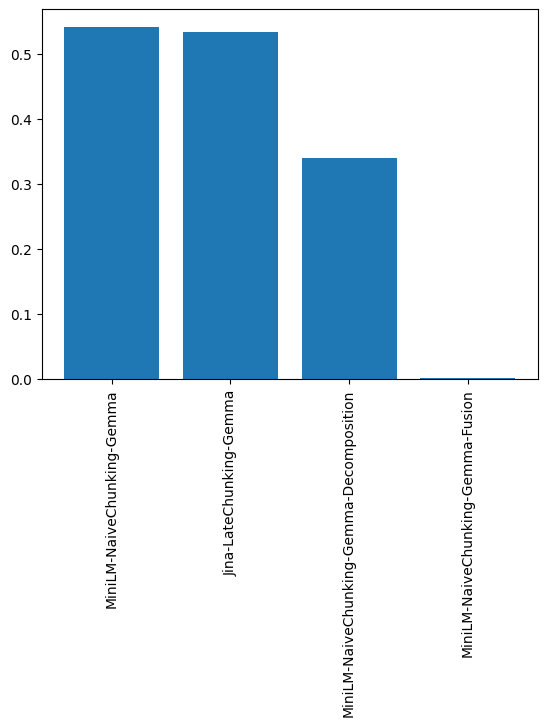

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

df_scores = pd.DataFrame(scores.items(), columns=["Method", "Score"])
print(df_scores)

plt.bar(scores.keys(), scores.values())
plt.xticks(rotation=90)
plt.show()